In [1]:
import numpy as np
import timeit

%alias_magic t timeit
%matplotlib inline

Created `%t` as an alias for `%timeit`.
Created `%%t` as an alias for `%%timeit`.


### Travel and infect kernel
Speeding up the travel and infection kernel. One of the slowest parts is the binomial simulation

In [2]:
def version1(n, p, m):
    infected_possibility = np.random.binomial(n, p, m)
    infected_possibility[infected_possibility > 0] = 1
    return np.sum(infected_possibility)

def version2(n, p, m):
    infected_possibility = np.random.geometric(p, m)
    infected_possibility[infected_possibility <= n] = 1
    infected_possibility[infected_possibility > n] = 0
    return np.sum(infected_possibility)

def version3(n, p, m):
    prob = 1 - (1 - p)**n
    return np.random.binomial(m, prob)

In [3]:
n = 10
p = 0.1
m = 5000
num_sim = 100
x1 = []
x2 = []
x3 = []

for i in range(num_sim):
    x1.append(version1(n, p, m))
    x2.append(version2(n, p, m))
    x3.append(version3(n, p, m))

print("Version 1 {:.3f}".format(np.mean(x1)))
print("Version 2 {:.3f}".format(np.mean(x2)))
print("Version 3 {:.3f}".format(np.mean(x3)))

Version 1 3258.600
Version 2 3255.250
Version 3 3254.650


In [4]:
%t version1(n, p, m)

806 µs ± 42.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
%t version2(n, p, m)

1.12 ms ± 47.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%t version3(n, p, m)

9.45 µs ± 318 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Recover kernel
The other bottleneck is the recover kernel. Especially np.random.choice and counting it

In [7]:
from collections import Counter
import random

In [8]:
def recover1(m, SIR):
    x = np.random.choice([0, 1, 2], m, p=SIR)
    recovered = len(x[x == 0])
    dead = len(x[x == 2])
    return recovered, dead

def recover2(m, SIR):
    x = np.random.choice([0, 1, 2], m, p=SIR)
    unique, counts = np.unique(x, return_counts=True)
    if 0 in unique:
        recovered = counts[0]
    else:
        recovered = 0
    if 2 not in unique:
        dead = 0
    elif 0 in unique and 1 in unique:
        dead = counts[2]
    elif (0 not in unique and 1 in unique) or (0 in unique and 1 not in unique):
        dead = counts[1]
    else:
        dead = counts[0]
    return recovered, dead

def recover3(m, SIR):
    x = np.random.choice([0, 1, 2], m, p=SIR)
    freq = Counter(x)
    recovered = freq[0]
    dead =freq[2]
    return recovered, dead

def recover4(m, SIR):
    x = np.random.uniform(0, 1, m)
    recovered = len(np.asarray(x < SIR[0]).nonzero()[0])
    dead = len(np.asarray(x <= SIR[2]).nonzero()[0])
    return recovered, max(0, dead)

def recover5(m, SIR):
    x = np.random.multinomial(m, SIR)
    recovered = x[0]
    dead = x[2]
    return recovered, dead

In [9]:
m = 5000
p_rec = 0.99
p_die = 7.540044190323758e-05
p_stay = 1 - p_rec - p_die
SIR = [p_rec, p_stay, p_die]

In [10]:
num_sim = 100

r1 = []
d1 = []

r4 = []
d4 = []

r5 = []
d5 = []

for i in range(num_sim):
    r, d = recover1(m, SIR)
    r1.append(r)
    d1.append(d)
    
    r, d = recover4(m, SIR)
    r4.append(r)
    d4.append(d)
    
    r, d = recover5(m, SIR)
    r5.append(r)
    d5.append(d)

print("Version 1 {:.3f}, {:.3f}".format(np.mean(r1), np.mean(d1)))
print("Version 4 {:.3f}, {:.3f}".format(np.mean(r4), np.mean(d4)))
print("Version 5 {:.3f}, {:.3f}".format(np.mean(r5), np.mean(d5)))

Version 1 4950.080, 0.360
Version 4 4950.880, 0.430
Version 5 4949.280, 0.280


In [11]:
%t recover1(m, SIR)

545 µs ± 14.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
%t recover2(m, SIR)

812 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
%t recover3(m, SIR)

3.66 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%t recover4(m, SIR)

275 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
%t recover5(m, SIR)

9.6 µs ± 762 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Seasonality plots

In [17]:
import matplotlib.pyplot as plt

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

%matplotlib inline

In [9]:
p = 0.8
a = 0.25
t = np.linspace(0, 12, 100)
p_season = p * (a * np.cos(np.pi / 6 * t) + (1 - a))

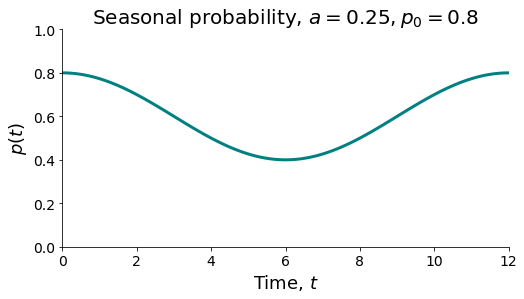

In [30]:
plt.figure(figsize=(8, 4))

plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

plt.plot(t, p_season, linewidth=3, color="teal", label="$p(t) = p_0 (a \cos(\pi t / 6) + (1 - a))$")

plt.title("Seasonal probability, $a = 0.25, p_0 = 0.8$", fontsize=20)
plt.xlabel("Time, $t$", fontsize=18)
plt.ylabel("$p(t)$", fontsize=18)

plt.xlim(0, 12)
plt.ylim(0, 1)

# plt.legend()

plt.savefig("../figures/seasonal.PNG", dpi=200, bbox_inches="tight")

plt.show()